In [11]:
!pip install scanpy anndata matplotlib scikit-learn
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency, kruskal

In [10]:
adata = sc.read_h5ad("/content/z-scaled.h5ad")

print(f"Shape of data: {adata.shape}")  # (n_samples, n_genes)
print("Metadata columns (adata.obs):", adata.obs.columns.tolist())
print("Gene info columns (adata.var):", adata.var.columns.tolist())

print(adata.obs.head())

Shape of data: (572, 19740)
Metadata columns (adata.obs): ['nCount_RNA', 'nFeature_RNA', 'cases.submitter_id', 'sample_id', 'total_expr', 'cases.consent_type', 'cases.days_to_consent', 'cases.disease_type', 'cases.lost_to_followup', 'demographic.age_at_index', 'demographic.age_is_obfuscated', 'demographic.country_of_residence_at_enrollment', 'demographic.days_to_birth', 'demographic.days_to_death', 'demographic.demographic_id', 'demographic.ethnicity', 'demographic.gender', 'demographic.race', 'demographic.submitter_id', 'demographic.vital_status', 'diagnoses.age_at_diagnosis', 'diagnoses.ajcc_pathologic_m', 'diagnoses.ajcc_pathologic_n', 'diagnoses.ajcc_pathologic_stage', 'diagnoses.ajcc_pathologic_t', 'diagnoses.ajcc_staging_system_edition', 'diagnoses.classification_of_tumor', 'diagnoses.days_to_diagnosis', 'diagnoses.diagnosis_id.x', 'diagnoses.diagnosis_is_primary_disease', 'diagnoses.figo_stage', 'diagnoses.figo_staging_edition_year', 'diagnoses.icd_10_code', 'diagnoses.lateralit


Running MDS with euclidean distance...


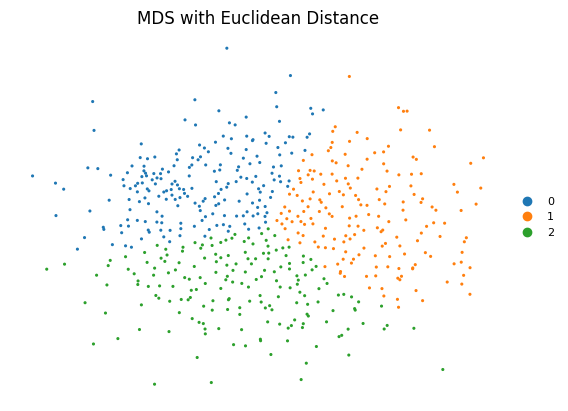


Running MDS with manhattan distance...


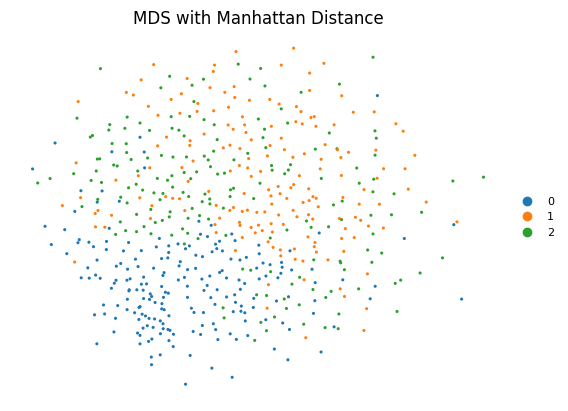


Running MDS with cosine distance...


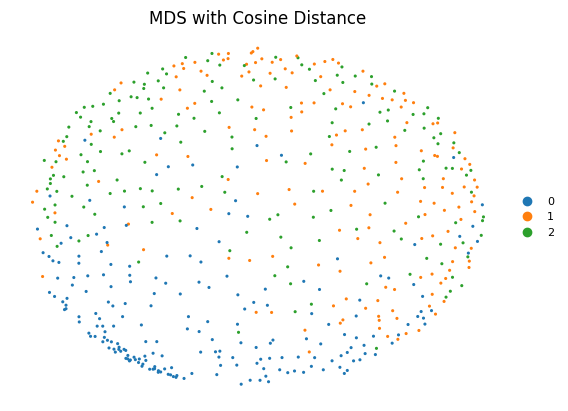

In [15]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# You can loop over several distance metrics
distance_metrics = ["euclidean", "manhattan", "cosine"]

for metric in distance_metrics:
    print(f"\nRunning MDS with {metric} distance...")

    # 1. Compute the distance matrix
    D = pairwise_distances(adata.X, metric=metric)

    # 2. Run MDS using the distance matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=4, max_iter=300)
    X_mds = mds.fit_transform(D)

    # 3. Store results in adata.obsm for plotting
    adata.obsm[f"X_mds_{metric}"] = X_mds

    # 4. Plot the results
    sc.pl.embedding(
        adata,
        basis=f"X_mds_{metric}",
        color="mds_cluster",  # You can change this to gender, tumor type, etc.
        title=f"MDS with {metric.capitalize()} Distance",
        size=20,
        legend_loc="right margin",
        frameon=False,
        legend_fontsize=8,
        show=True
    )


Shape of data: (572, 19740)

Running MDS with euclidean distance...


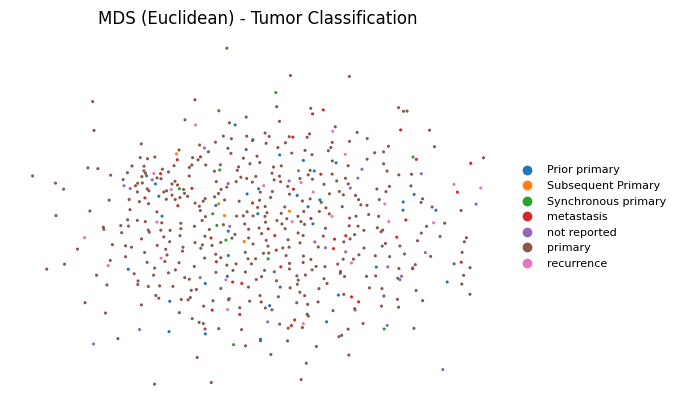

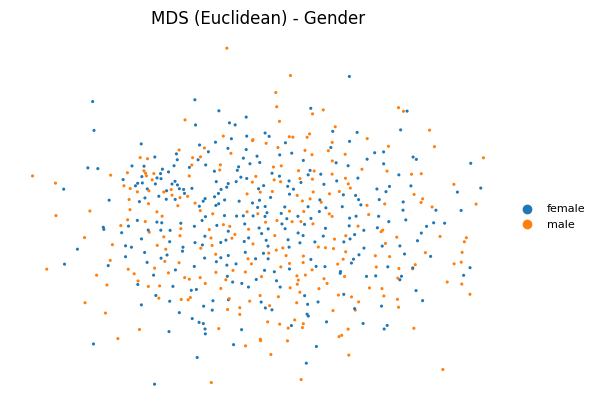

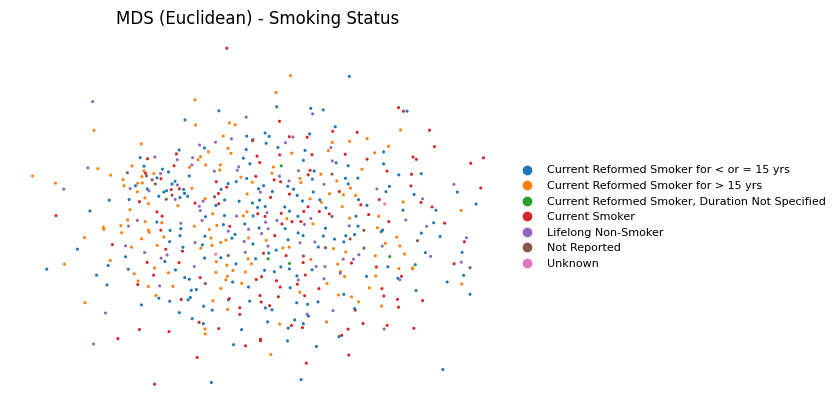

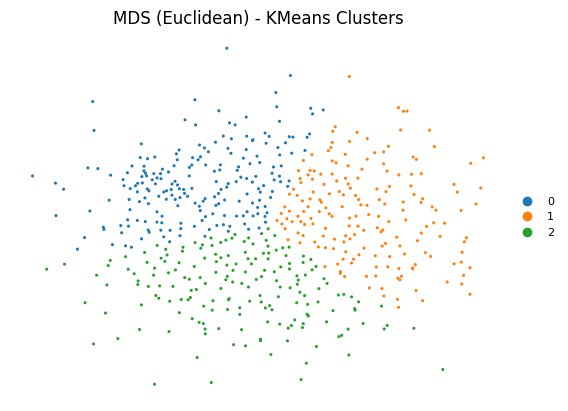


Running MDS with manhattan distance...


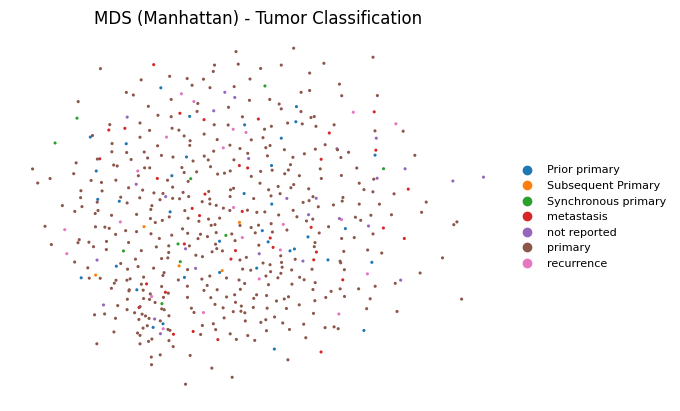

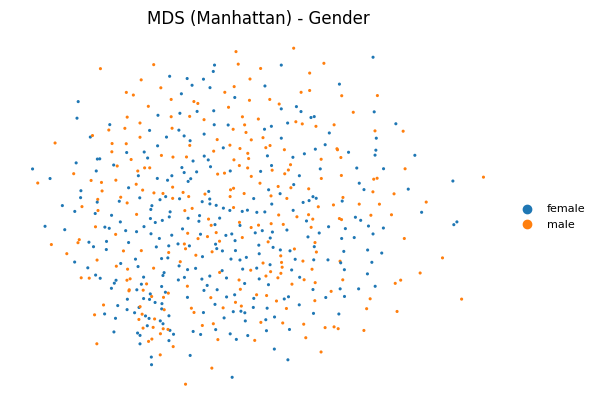

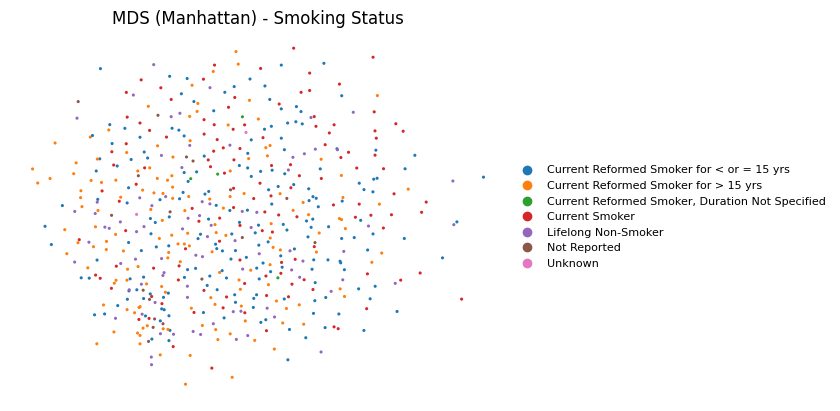

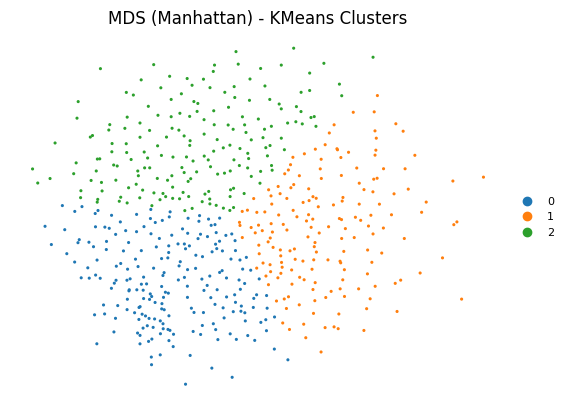


Running MDS with cosine distance...


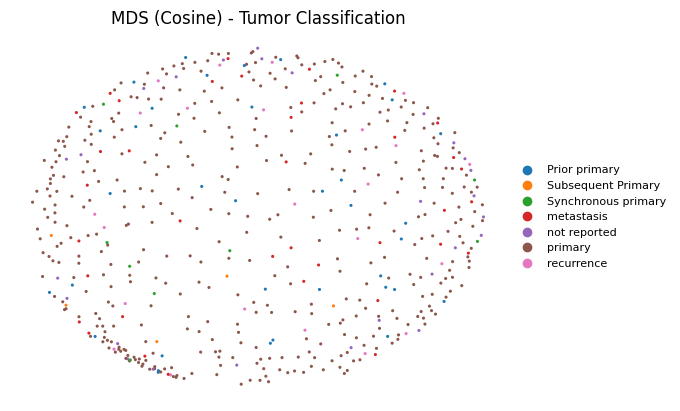

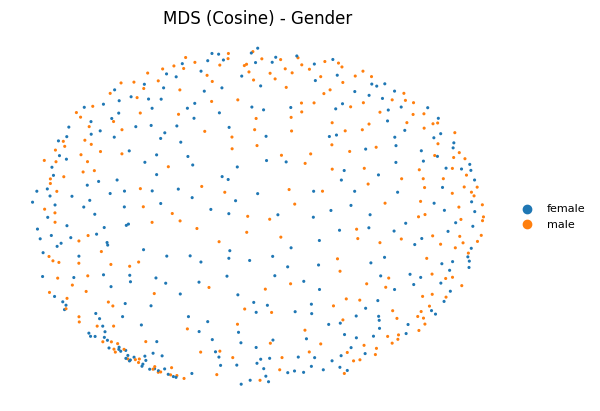

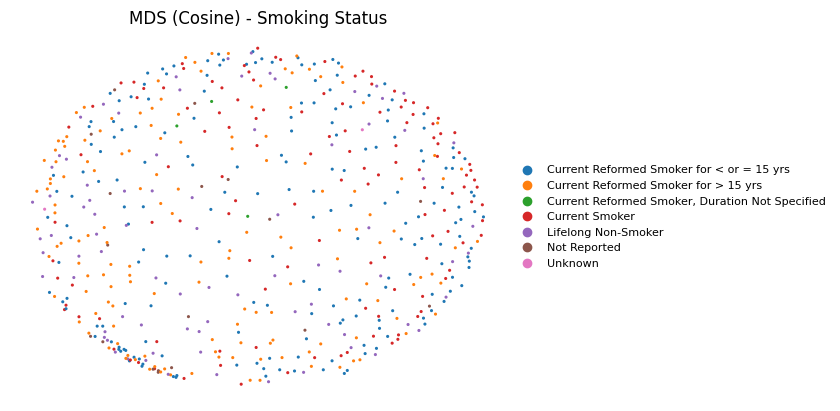

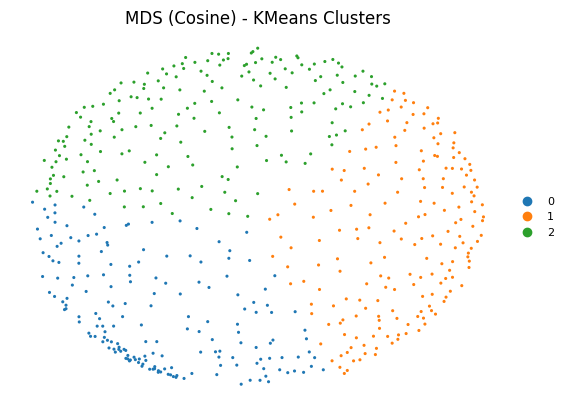

In [16]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import scanpy as sc
import matplotlib.pyplot as plt

# Load data
adata = sc.read_h5ad("/content/z-scaled.h5ad")
print(f"Shape of data: {adata.shape}")

# Distance metrics to try
distance_metrics = ["euclidean", "manhattan", "cosine"]

# Features to plot
features_to_plot = [
    ("diagnoses.classification_of_tumor", "Tumor Classification"),
    ("demographic.gender", "Gender"),
    ("exposures.tobacco_smoking_status", "Smoking Status"),
]

for metric in distance_metrics:
    print(f"\nRunning MDS with {metric} distance...")

    # 1. Compute distance matrix
    D = pairwise_distances(adata.X, metric=metric)

    # 2. Run MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=4, max_iter=300)
    X_mds = mds.fit_transform(D)

    # 3. Store in adata
    adata.obsm[f"X_mds_{metric}"] = X_mds

    # 4. Cluster with KMeans on new MDS
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_mds)
    adata.obs[f"mds_cluster_{metric}"] = kmeans.labels_.astype(str)

    # 5. Plot metadata features
    for feature, label in features_to_plot:
        sc.pl.embedding(
            adata,
            basis=f"X_mds_{metric}",
            color=feature,
            title=f"MDS ({metric.capitalize()}) - {label}",
            size=20,
            legend_loc="right margin",
            frameon=False,
            legend_fontsize=8,
            show=True
        )

    # 6. Plot clusters
    sc.pl.embedding(
        adata,
        basis=f"X_mds_{metric}",
        color=f"mds_cluster_{metric}",
        title=f"MDS ({metric.capitalize()}) - KMeans Clusters",
        size=20,
        legend_loc="right margin",
        frameon=False,
        legend_fontsize=8,
        show=True
    )


In [17]:
from scipy.stats import chi2_contingency, kruskal
import pandas as pd

distance_metrics = ["euclidean", "manhattan", "cosine"]

for metric in distance_metrics:
    print(f"\n--- Metadata tests for MDS with {metric} distance ---")

    # Gender vs cluster
    contingency_gender = pd.crosstab(adata.obs[f"mds_cluster_{metric}"], adata.obs["demographic.gender"])
    chi2, p_gender, _, _ = chi2_contingency(contingency_gender)
    print(f"Chi-square p-value for Gender vs Cluster ({metric}): {p_gender:.4f}")

    # Smoking status vs cluster
    contingency_smoking = pd.crosstab(adata.obs[f"mds_cluster_{metric}"], adata.obs["exposures.tobacco_smoking_status"])
    chi2, p_smoking, _, _ = chi2_contingency(contingency_smoking)
    print(f"Chi-square p-value for Smoking Status vs Cluster ({metric}): {p_smoking:.4f}")

    # Age at diagnosis vs cluster
    groups = []
    for c in sorted(adata.obs[f"mds_cluster_{metric}"].unique()):
        group = adata.obs.loc[adata.obs[f"mds_cluster_{metric}"] == c, "diagnoses.age_at_diagnosis"].dropna()
        groups.append(group)

    kw_stat, p_age = kruskal(*groups)
    print(f"Kruskal-Wallis p-value for Age at Diagnosis vs Cluster ({metric}): {p_age:.4f}")



--- Metadata tests for MDS with euclidean distance ---
Chi-square p-value for Gender vs Cluster (euclidean): 0.0505
Chi-square p-value for Smoking Status vs Cluster (euclidean): 0.1878
Kruskal-Wallis p-value for Age at Diagnosis vs Cluster (euclidean): 0.3010

--- Metadata tests for MDS with manhattan distance ---
Chi-square p-value for Gender vs Cluster (manhattan): 0.0006
Chi-square p-value for Smoking Status vs Cluster (manhattan): 0.0001
Kruskal-Wallis p-value for Age at Diagnosis vs Cluster (manhattan): 0.0872

--- Metadata tests for MDS with cosine distance ---
Chi-square p-value for Gender vs Cluster (cosine): 0.0125
Chi-square p-value for Smoking Status vs Cluster (cosine): 0.0000
Kruskal-Wallis p-value for Age at Diagnosis vs Cluster (cosine): 0.0620
